## Note
when runnig each policy run the first cell each time because training and testing have a different condition to start on origin or not

And policy that use use V(S) instead of q(s,a) run the cell that extracts the q(s,a) then extract the optimal actions/policy

In [27]:
from gymnasium import Env
import time
from math import gamma

import gymnasium as gym
import numpy as np
from gymnasium.envs.toy_text import frozen_lake


size = 10
seed =1

map = frozen_lake.generate_random_map(size,seed=seed,p=0.8)


class CustomGymEnv(frozen_lake.FrozenLakeEnv):
    def __init__(self,render_mode,desc = map,is_slippery = False,start_at_goal = False):
        self.desc = desc = np.asarray(desc, dtype="c")
        super().__init__(desc = self.desc,is_slippery=is_slippery,render_mode=render_mode)
        #self.desc = desc = np.asarray(desc, dtype="c")
        self.start_at_goal = start_at_goal
        self.reward_range=(-1,1)
        self.nA = 8
        self.action_space = gym.spaces.Discrete(self.nA)
        self.initial_state_distrib = np.array(desc == b"F").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.size = size
        self.s = 0
        nrow, ncol = self.nrow, self.ncol
        nS = nrow * ncol
        self.P = {s: {a: [] for a in range(self.nA)} for s in range(nS)}

        def to_s(row,col):
            return row*ncol+col


        def inc(row,col,action):
          if action == 0:  # LEFT
            col = max(col-1, 0)
          elif action == 1:  # DOWN
            row = min(row+1, self.size-1)
          elif action == 2:  # RIGHT
            col = min(col+1, self.size-1)
          elif action == 3:  # UP
            row = max(row-1, 0)
          elif action == 4:  # DOWN-LEFT
            row = min(row+1, self.size-1)
            col = max(col-1, 0)
          elif action == 5:  # DOWN-RIGHT
           row = min(row+1, self.size-1)
           col = min(col+1, self.size-1)
          elif action == 6:  # UP-LEFT
           row = max(row-1, 0)
           col = max(col-1, 0)
          elif action == 7:  # UP-RIGHT
           row = max(row-1, 0)
           col = min(col+1, self.size-1)
          return row, col
        def phi(state, goal=(99, 99)):
         return -(abs(state%size - goal[0]) + abs(state/size - goal[1]))//100

        def shaped_reward(reward, state, next_state, gamma=0.5):
         return reward + gamma * phi(next_state) - phi(state)
        def update_probability_matrix(row, col, action, state):
           old_state = to_s(row, col)
           new_row, new_col = inc(row, col, action)
           if (new_row, new_col) == (row, col):
             edge_penalty = -0.1
             return old_state, edge_penalty , False

           new_state = to_s(new_row, new_col)
           new_letter = desc[new_row, new_col]
           terminated = bytes(new_letter) in b"GH"

           if new_letter == b"G":
            reward = float(10)
           elif new_letter == b"H":
            reward = float(-2)
           # elif new_letter == b"F":
           #  reward = shaped_reward(1, state, new_state)
           #  #reward = float(0)
           # elif new_letter == b"S":
           #  reward = -1
           else:
               reward = float(-0.01)
           return new_state, reward, terminated
        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                      #this part is wrong but is not used since i  have turend off slippery since it was not converging in most case but we could assume the slippery concept works like this                        li.append((1.0, *update_probability_matrix(row,col,a,s)))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b,s))
                                )
                        else:
                            li.append((1.0, *update_probability_matrix(row, col, a,s)))

    def step(self, a):
     transitions = self.P[self.s][a]

     i = self.np_random.choice(len(transitions), p=[t[0] for t in transitions])
     p, s, r, t = transitions[i]

     self.s = s
     if(a<=3):
      self.lastaction = a
     else:
      self.lastaction = a%4

     if self.render_mode == "human":
        self.render()

     return (int(s), r, t, False, {"prob": p})

    def reset(self,seed=seed,options=None):
        Env.reset(self,seed = seed)
        start_at_goal = self.start_at_goal
        if start_at_goal:
            self.s = 0
            self.lastaction = None
        else:
            self.s = np.random.choice(np.arange(1,self.size**2))
            self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}




In [2]:
gym.register("MyENVTD","__main__:CustomGymEnv",kwargs={'render_mode': 'ansi', 'start_at_goal': False} )
env = CustomGymEnv(render_mode = "human")
env = gym.make("MyENVTD",render_mode = "ansi")
state = env.reset()

Lambda = 3
V = np.zeros(size**2)
gamma = 0.99
episodes = 100000
a = 0.1

for e in range(episodes):
    state,_ = env.reset()
    episodeHistory = []
    state_visited = []
    for l in range(Lambda):
        action = env.action_space.sample()
        nxt_state, reward, terminated,info,_ = env.step(action)
        episodeHistory.append((state,reward))
        if nxt_state in state_visited:
            reward = -1
        state_visited.append(nxt_state)
        if terminated or len(episodeHistory) > Lambda:
            episodeHistory.append((nxt_state,V[nxt_state]))
            G = 0
            for s,r in episodeHistory:
                G += gamma*r
                V[s] += a*(G-V[s])
            # s_t = episodeHistory[0][0]
            # V[s_t] += a*(G-V[s_t])
            break
        state = nxt_state


In [16]:
#q-learing
#converged at around 400k episodes
gym.register("MyENVTD","__main__:CustomGymEnv",kwargs={'render_mode': 'ansi', 'start_at_goal': False} )
env = CustomGymEnv(render_mode = "human")
env = gym.make("MyENVTD",render_mode = "ansi")
state = env.reset()


import numpy as np

alpha = 0.1
gamma = 0.99
epsilon = 0.2
episodes = 15000

Q = np.zeros((size**2, env.action_space.n))
max_steps = size * 4

for epochs in range(episodes):
    state, _ = env.reset()
    done = False
    steps = 0
    if epochs % 10000 == 0:
        print("Episode:", epochs)
    while not done and steps < max_steps:
        steps += 1
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        next_state, reward, done, _, _ = env.step(action)

        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

        state = next_state

Episode: 0
Episode: 10000


In [28]:
gym.register("MyENVTD","__main__:CustomGymEnv",kwargs={'render_mode': 'ansi', 'start_at_goal': False} )
env = CustomGymEnv(render_mode = "human")
env = gym.make("MyENVTD",render_mode = "ansi")
state = env.reset()



Q1 = np.zeros((size**2, env.action_space.n))
Q2 = np.zeros((size**2, env.action_space.n))
alpha = 0.1
gamma = 0.99
epsilon = 0.2
episodes = 10000
for episode in range(episodes):
    state, _ = env.reset()
    done = False
    steps = 0
    if episode % 10000 == 0:
        print("Episode:", episode)
    while not done and steps < max_steps:
        steps += 1
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q1[state] + Q2[state])

        next_state, reward, done, _, _ = env.step(action)

        if np.random.rand() < 0.5:
            best_action = np.argmax(Q1[next_state])
            td_target = reward + gamma * Q2[next_state][best_action]
            Q1[state][action] += alpha * (td_target - Q1[state][action])
        else:
            best_action = np.argmax(Q2[next_state])
            td_target = reward + gamma * Q1[next_state][best_action]
            Q2[state][action] += alpha * (td_target - Q2[state][action])

        state = next_state
Q = Q1 + Q2

Episode: 0


In [24]:
#saras learing
gym.register("MyENVTD","__main__:CustomGymEnv",kwargs={'render_mode': 'ansi', 'start_at_goal': False} )
env = CustomGymEnv(render_mode = "human")
env = gym.make("MyENVTD",render_mode = "ansi")
state = env.reset()



import numpy as np

alpha = 0.1
gamma = 0.99
epsilon = 0.4
episodes = 15000
state_visited = np.zeros(size**2,dtype=bool)

Q = np.full((size**2, env.action_space.n),1.0)
max_steps = size * 10
x = 0
for epochs in range(episodes):
    state, _ = env.reset()
    done = False
    steps = 0
    # if epochs % 100 == 0:
    #     print("Episode:", epochs)

    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    while not done and steps<=max_steps :
        steps += 1
        state_visited[state] = True
        if steps == max_steps:
            reward = -0.1
        next_state, reward, done, _, _ = env.step(action)
        if np.random.rand() < epsilon:
            action_nxt = env.action_space.sample()
        else:
            action_nxt = np.argmax(Q[next_state])
        old_q = Q[state, action]
        Q[state, action] += alpha * (reward + gamma * Q[next_state][action_nxt] - Q[state, action])
        if Q[state, action] == 0 and old_q != 0:
           x +=1
        elif Q[state, action] != 0 and old_q == 0:
            x -=1
        state = next_state
        action = action_nxt
    if (epochs + 1) % 10_000 == 0:
        print(f"Episode: {epochs + 1}, Q-table sum: {np.sum(Q)}")
        print(x)

Episode: 10000, Q-table sum: 4530.259198286527
0


In [181]:
for i in Q:
    print(i)

[-0.1850983  -0.18477684 -0.9995789  -0.1850876  -0.18459675 -0.18487568
 -0.18439267 -1.0013655 ]
[-0.05478276 -0.06644885 -0.05657738 -0.1        -0.05986111 -0.19232459
 -0.06231124 -0.05125163]
[-0.90792328 -0.86037415 -0.89900047 -0.18345563 -0.18444458 -0.18372375
 -0.76606188 -0.85228345]
[-0.05230249 -0.05828679 -0.05631195 -0.19412169 -0.19130818 -0.1
 -0.0470353  -0.05141164]
[-0.99967003 -0.96931982 -0.18494268 -0.1857097  -0.18572573 -0.18520909
 -0.9660189  -0.18536993]
[-0.18537742 -0.18608523 -0.96484321 -0.18531305 -0.95994537 -0.18534313
 -0.18567864 -0.97517257]
[-0.05708127 -0.06402835 -0.04884618 -0.19       -0.05305714 -0.05670701
 -0.04622611 -0.04733557]
[-1.00991923 -0.18689402 -0.18692144 -0.18684358 -0.18697712 -0.98715743
 -0.93850654 -0.18743208]
[-0.18742355 -1.00323101 -0.18750702 -0.18733896 -0.18775497 -0.18783272
 -0.18720162 -0.18706919]
[-0.18802192 -0.18812749 -0.18855356 -0.18772084 -1.00475875 -0.18821543
 -0.18769516 -0.18804462]
[-0.18917272 -0.1

In [3]:
env = env.unwrapped
n_states = len(env.P)
n_actions = len(env.P[0])
optimal_policy = np.zeros(n_states)

for s in range(n_states):
    q = np.zeros(n_actions)
    for a in range(n_actions):
        for prob,next_state,reward, terminated in env.P[s][a]:
            q[a] += prob*(reward+gamma*V[next_state])
    optimal_policy[s] = np.argmax(q)
    if env.P[s][optimal_policy[s]][0][1] == s:
        print(s)
        optimal_policy[s] = np.argsort(q)[-2]
optimal_policy = optimal_policy.astype(dtype = int)
# for s in optimal_policy:
#     print(s)

99


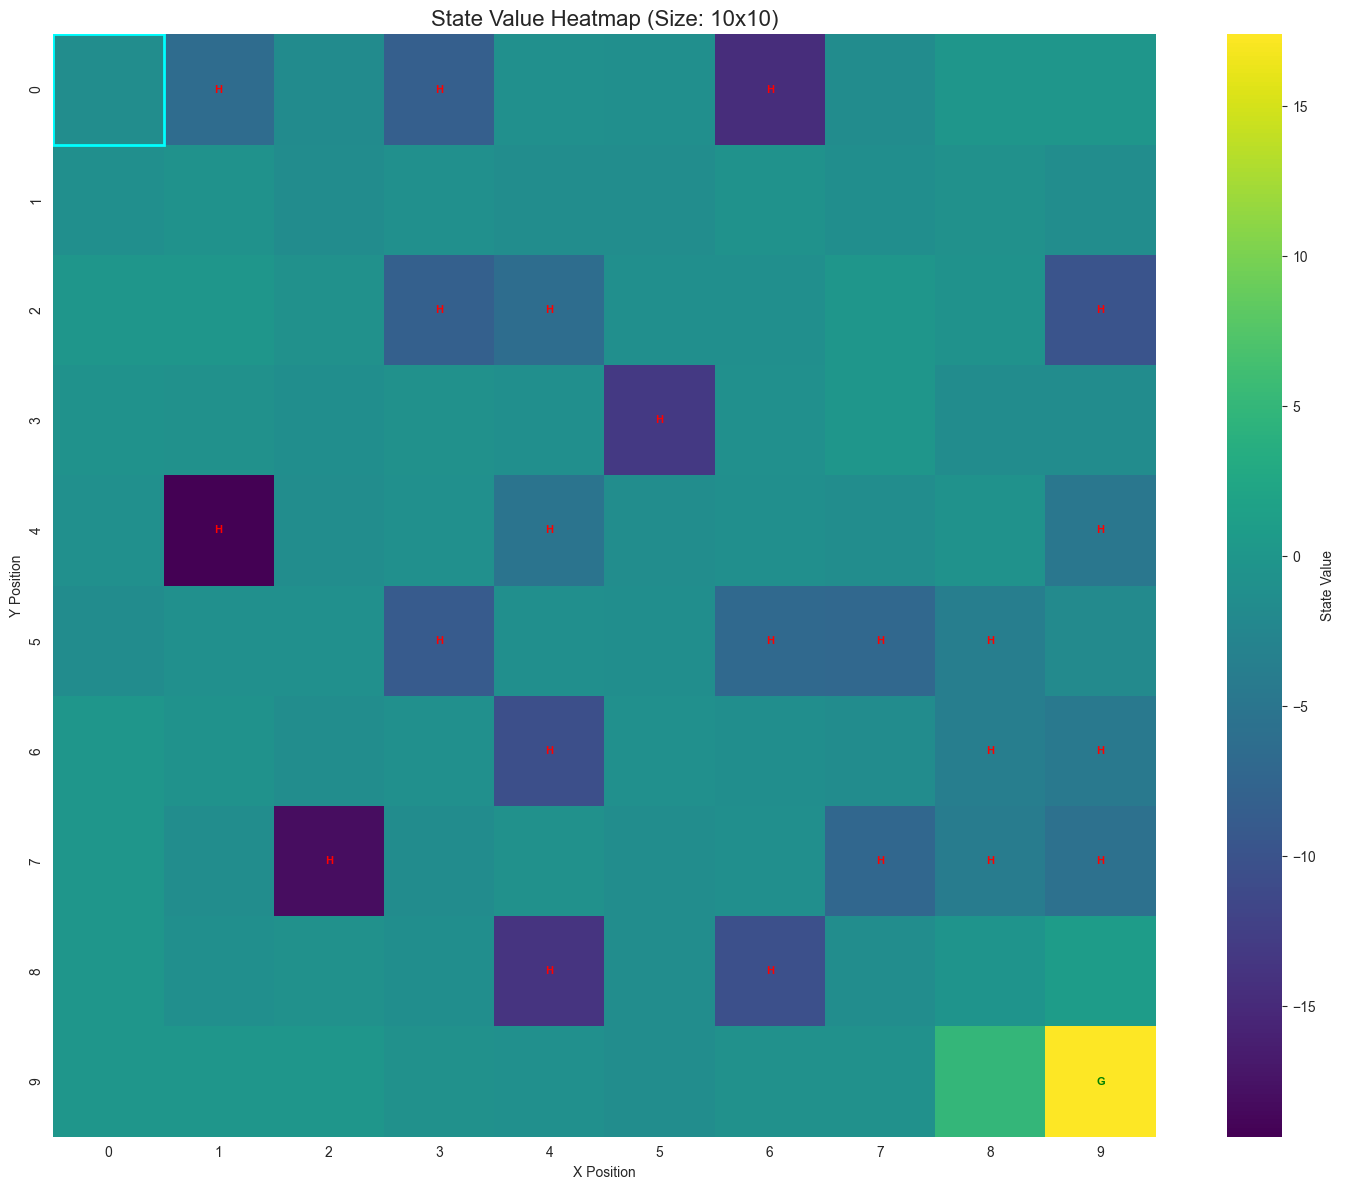

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Reshape value function to 2D grid
value_grid = V.reshape((size, size))

# Create heatmap
plt.figure(figsize=(15, 12))
ax = sns.heatmap(
    value_grid,
    cmap="viridis",
    annot=False,  # Don't show values (too dense for large grid)
    cbar_kws={'label': 'State Value'},
    square=True
)

# Overlay environment elements
map_chars = env.desc.astype(str)
for i in range(size):
    for j in range(size):
        char = map_chars[i, j]
        color = "white"
        if char == "S":  # Start
            color = "cyan"
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor=color, lw=2))
        elif char == "G":  # Goal
            color = "green"
            ax.text(j + 0.5, i + 0.5, "G",
                    fontsize=8, ha='center', va='center', color=color, fontweight='bold')
        elif char == "H":  # Hole
            color = "red"
            ax.text(j + 0.5, i + 0.5, "H",
                    fontsize=8, ha='center', va='center', color=color, fontweight='bold')

# Add title and labels
plt.title(f"State Value Heatmap (Size: {size}x{size})", fontsize=16)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.tight_layout()

# Save and show
plt.savefig(f"frozenlake_values_{size}x{size}.png", dpi=300)
plt.show()

In [29]:
optimal_policy = np.array([np.argmax(q) for q in Q])
for s in optimal_policy:
    print(s)

5
7
4
1
7
5
5
1
4
0
5
5
1
4
0
5
1
4
0
6
5
5
1
4
4
5
1
4
6
6
2
2
5
1
4
5
4
0
6
0
1
1
2
5
0
1
4
6
0
6
5
1
4
2
2
5
1
6
4
6
5
1
5
5
1
5
1
4
0
7
2
5
5
1
5
1
4
1
1
4
7
2
2
5
1
5
2
2
1
1
2
7
2
5
7
5
2
2
2
4


In [30]:
env = gym.make("MyENVTD",render_mode = "human",start_at_goal = True)
state,_ = env.reset()
max_steps = 100
R=0
epsilon = 0.8
win = 0
for i in range(100):
 while True:
    action = optimal_policy[state]
    #print(f"State {state} Action {action}")
    observation, reward, terminated, truncated,info = env.step(action)
    state = observation
    R += reward
    print(f"state: {state}")
    if terminated or truncated:
        print(state,R,i)
        print(map[state//size][state%size])
        if state == size**2-1:
            win += 1
        break
 if state == size**2-1:
     print("goal reached")
     break
env.close()

state: 11
state: 22
state: 32
state: 43
state: 54
state: 55
state: 66
state: 76
state: 85
state: 96
state: 97
state: 98
state: 99
99 9.88 0
G
goal reached
